In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using FFTW
using BenchmarkTools
using Distributions
using Unwrap
using JuMP
using Ipopt
using Unwrap
using Pkg
# Pkg.add("PyCall") 

In [ ]:
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(ifft(ifftshift(B)))
end

ifftnshift (generic function with 1 method)

In [3]:
function fft_1dcustom!(x_re, x_im)
    N = length(x_re)
    @assert N == length(x_im) "re/im must match length"
    @assert ispow2(N) "Length must be a power of two"

    # Bit‑reversal on both real & imag
    bits = Int(floor(log2(N)))
    for i in 0:N-1
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            x_re[i+1], x_re[j+1] = x_re[j+1], x_re[i+1]
            x_im[i+1], x_im[j+1] = x_im[j+1], x_im[i+1]
        end
    end

    # Cooley‑Tuk stages
    m = 1
    while m < N
        half = m
        m *= 2
        θ = -2π / m
        @inbounds for j in 0:half-1
            c = cos(θ*j)     # real constant :contentReference[oaicite:8]{index=8}
            s = sin(θ*j)
            for k in j:m:N-1
                u = k + 1
                v = k + half + 1
                u_re, u_im = x_re[u], x_im[u]
                v_re, v_im = x_re[v], x_im[v]

                # complex multiply (v * cis(θ*j)) in real form
                t_re =  c*v_re - s*v_im
                t_im =  s*v_re + c*v_im

                # butterfly
                x_re[u] = u_re + t_re
                x_im[u] = u_im + t_im
                x_re[v] = u_re - t_re
                x_im[v] = u_im - t_im
            end
        end
    end

    return nothing
end
function fft_2dcustom(A)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = fft_1dcustom!(view(B, :, x, 1), view(B, :, x, 2))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = fft_1dcustom!(view(B, y, :, 1), view(B, y, :, 2))
    end

    return B
end

fft_2dcustom (generic function with 1 method)

In [4]:
function Find_Crossing(func, y_point, x)
    N = length(func)
    f = func .- y_point
    x_intercepts = []

    for i in 1:N-1
        if f[i]*f[i+1] < 0
            # Linear interpolation to find the crossing point
            dfdx = (f[i+1] - f[i]) / (x[i+1] - x[i])
            x_intercept = x[i] - f[i]/dfdx
            x_intercepts = push!(x_intercepts, x_intercept)
        end
        
    end
    return x_intercepts
end
function Find_Spacing(x_intercepts)
    if length(x_intercepts) == 0
        return Inf
    end


    if mod(length(x_intercepts),2) == 1
        x_intercepts = x_intercepts[1:end-1]
    end
    centers = @. (x_intercepts[1:2:end] + x_intercepts[2:2:end])/2
    
    spacing = centers[2:end] .- centers[1:end-1]
    spacing = sort!(spacing)
    return spacing[length(spacing)÷2]
end

Find_Spacing (generic function with 1 method)

In [5]:
function Diff_Image(image, c=0.01)
    return @. log1p(c*abs(image))
end
function Autocorrelation(image)
    # the image is assumed to be in real space
    
    image_fft = fftnshift(image)
    image_auto = ifftnshift(image_fft .* conj.(image_fft))
    if eltype(image) <: Real 
        return real.(image_auto)
    end
    return image_auto
end
function Autocorrelation_Normalized(image)
    # the image is assumed to be in real space
    Ny, Nx = size(image)
    image_auto = Autocorrelation(image)
    image_auto = image_auto./(Ny*Nx)
    image_auto = image_auto .- sum(image_auto)/(Ny*Nx)
    image_auto = image_auto ./ maximum(abs.(image_auto))
    return image_auto
end

Autocorrelation_Normalized (generic function with 1 method)

In [6]:
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀ = 511 #keV
    return hc/sqrt(E*(2*E₀ + E))
end

function Focus(E, Cs, nᵢ=1)
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

kmax (generic function with 1 method)

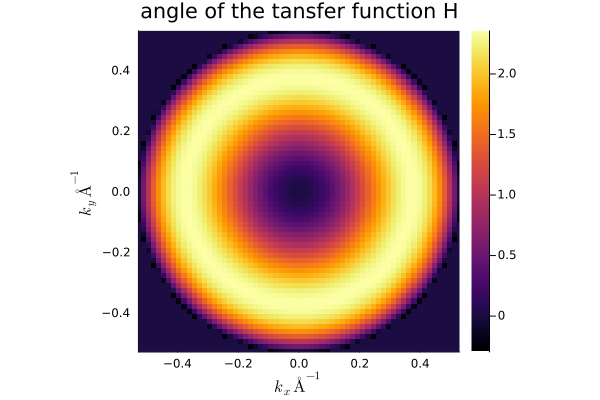

In [182]:
E = 300
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms

N = 2^6
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = lower:1:upper
ky = lower:1:upper

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)

Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = LinRange(-L/2, L/2, N)
y = LinRange(-L/2, L/2, N)

λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)
χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
H = @. exp(-1im*χ(k)*disk)*disk
f(x, y, xc, yc, σ₁, σ₂) = @. (1/((2*pi)*sqrt(σ₁*σ₂)))*exp(-(x - xc)^2/(2σ₁^2) -(y - yc)^2/(2σ₂^2) )
heatmap(kx, ky, angle.(H), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])

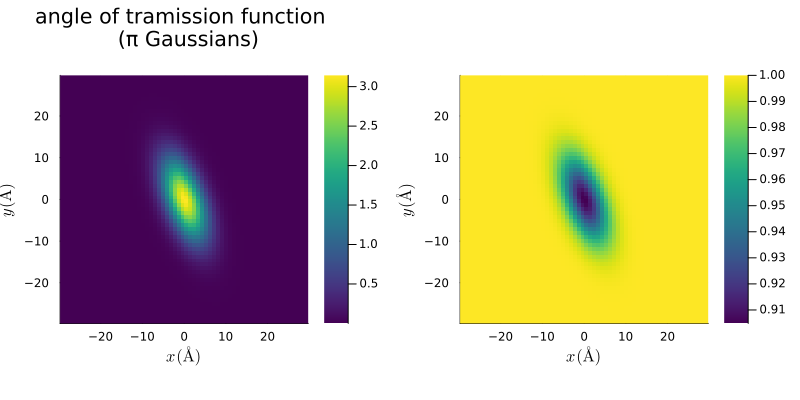

In [183]:
S = 5
σ₊, σ₋ = 7, 7
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
# indices = round.(Int, LinRange(1, N, S))

# for i in indices, j in indices
#     xc = x[i]
#     yc = y[j]
#     phase_real += f(x',y, xc, yc, σ₊, σ₋)
#     phase_complex += f(x',y, xc, yc, σ₊, σ₋) 
# end
xc, yc = 0.0, 0.0
σx, σy = 3, 7
θ_rot = deg2rad(20)
rotatedx = @. cos(θ_rot)*x' + sin(θ_rot)*y
rotatedy = @. -sin(θ_rot)*x' + cos(θ_rot)*y
phase_real = f(rotatedx,rotatedy, xc, yc, σx, σy)
phase_complex = f(rotatedx,rotatedy, xc, yc, σx, σy) 


phase_real = phase_real./maximum(phase_real) *π
phase_complex = phase_complex./maximum(phase_complex) * 0.1
phase = phase_real + 1im*phase_complex

transmission = @. exp(1im * phase);

fig1 = heatmap(x,y,abs.(phase), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)
title!("angle of tramission function \n (π Gaussians)")
# vline!([spacing_x], color=:black, lw=2)
# hline!([spacing_y], color=:black, lw=2)

fig2 = heatmap(x,y,abs.(transmission), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)

plot(fig1, fig2, layout=(1,2), size=(800, 400), legend=false)

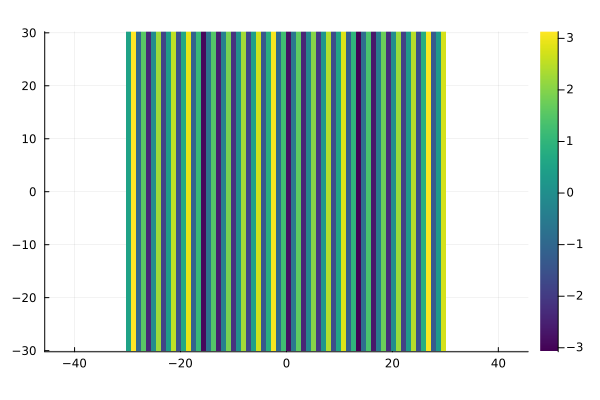

In [184]:
Reference_Wave(θ, ϕ) = @. exp(1im * 2*π/kmax(E,Cs) * (sin(θ)*cos(ϕ)*x' + sin(θ)*sin(ϕ)*y))
wave_ref = ifftnshift(fftnshift(Reference_Wave(0.2, 0)).*H)
transmission = @. exp(1im * phase);
heatmap(x, y, angle.(wave_ref), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)


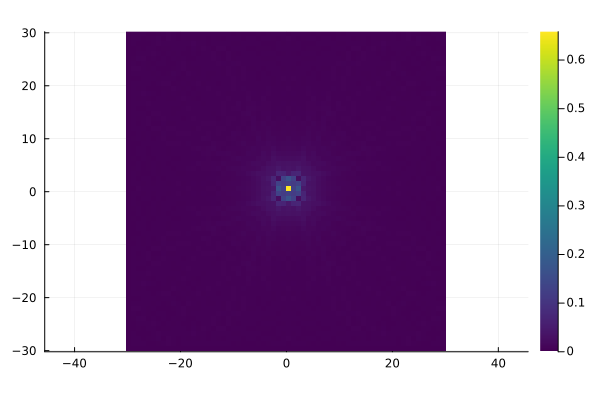

In [ ]:
probe = ifftnshift(H)
probe = probe./sqrt(sum(abs2.(probe)))
heatmap(x, y, abs.(probe), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

In [186]:
raster_shifts = @. exp(1im*2π*(kx' * x' + ky * y))

heatmap(x, y, angle.(raster_shifts), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=true, 
    xlabel="x", 
    ylabel="y");

In [187]:
function Rasters_fft(raster_shifts, tf_wave_fft, H)
    Ny, Nx = size(raster_shifts)
    # rasters_fft = Array{ComplexF64}(undef, N, N, N, N)
    common_factor = @. tf_wave_fft * H  # element-wise multiplication of tf_wave_fft and H
    rasters_fft = reshape(raster_shifts, Ny, Nx, 1, 1) .* reshape(common_factor, 1, 1, Ny, Nx)
    return rasters_fft
end

Rasters_fft (generic function with 1 method)

In [188]:
wave_obj_fft = fftnshift(transmission.*probe)
rasters_fft = Rasters_fft(raster_shifts, wave_obj_fft, H);

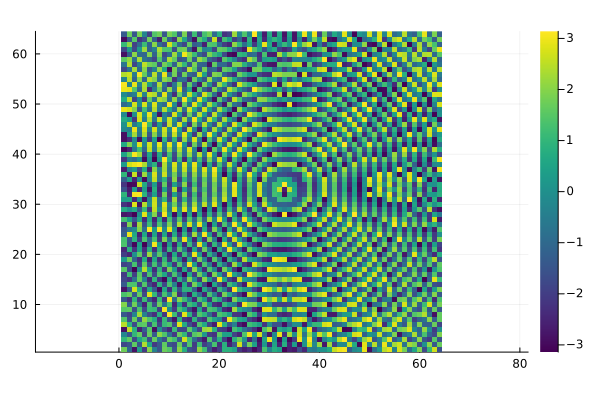

In [193]:
heatmap(angle.(ifftnshift(rasters_fft[1, 1, :, :])), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

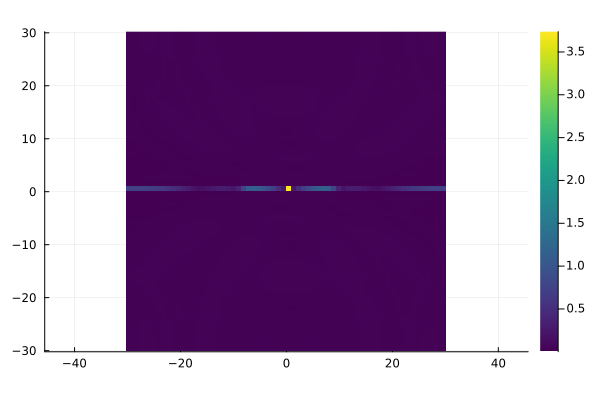

In [196]:

measurement(i,j) = abs2.(wave_ref .+ ifft(rasters_fft[i,j,:,:]))
measurement_fft(i,j) = @. fftnshift(measurement(i,j))
measurement_autocorr(i,j) = Autocorrelation_Normalized(measurement(i,j))
heatmap(x, y, Diff_Image(measurement_fft(1,1)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true) 
# heatmap(kx, ky, Diff_Image(measurement_fft(30,30)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true); 

In [ ]:
# Pkg.add("FiniteDifferences")
using FiniteDifferences

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
Precompiling project...
           ✗ BlackBoxOptim → BlackBoxOptimRealtimePlotServerExt
  0 dependencies successfully precompiled in 2 seconds. 688 already precompiled.


In [1]:
shift = -1
k, l = 15, 34
plot(x,abs.(measurement_fft(k,l)[N÷2-shift,:]), label="FFT of measurement", legend=:topright)
ylims!(0,maximum(abs.(measurement_fft(k,l)))*1)

UndefVarError: UndefVarError: `plot` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

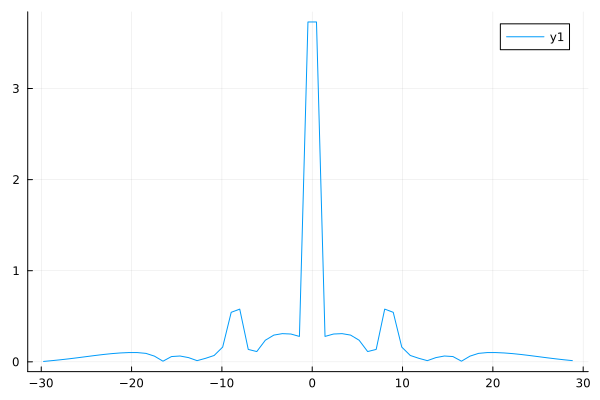

In [216]:
plot(x[1:end-1],Diff_Image(diff(abs.(measurement_fft(k,l)[N÷2-shift,:]))))

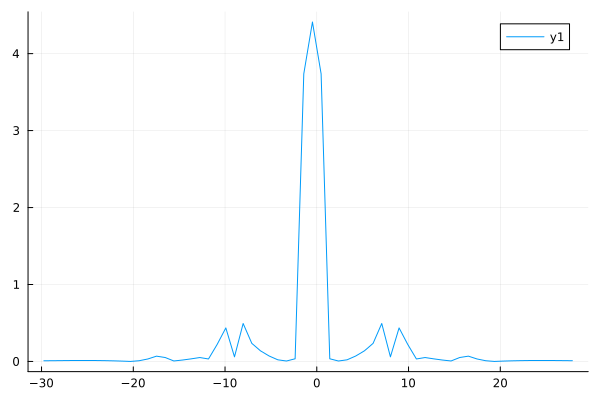

In [215]:
plot(x[1:end-2],Diff_Image(diff(diff(abs.(measurement_fft(k,l)[N÷2-shift,:])))))